# Autoencoder

- Autoencoder is a type of neural network that is capable of learning representations of the input data (i.e. codings) without supervision or in other terms, a dataset witout class labels. 


- The functionality of the codings typically creates a lower dimensionaity that the input, thus being useful to dimensionality reduction. Autoencoders are powerful in detecting features that can be used to train a neural network.


- Two parts make up and autoencoder. First, the encoder, which converts the input vector into an internal representation. Second is the decoder, which takes the encoded representation and converts it to the output. 


- Similar to the Multi-Layer Perceptron structure, except the number of neurons in the output layer must equal the number of inputs.


- Autoencoders can have multiple hidden layers, which is known is deep autoencoders, where more layers helps the algorithm learn more complex codings -- caution about overfitting. 


In [4]:
from IPython.display import Image

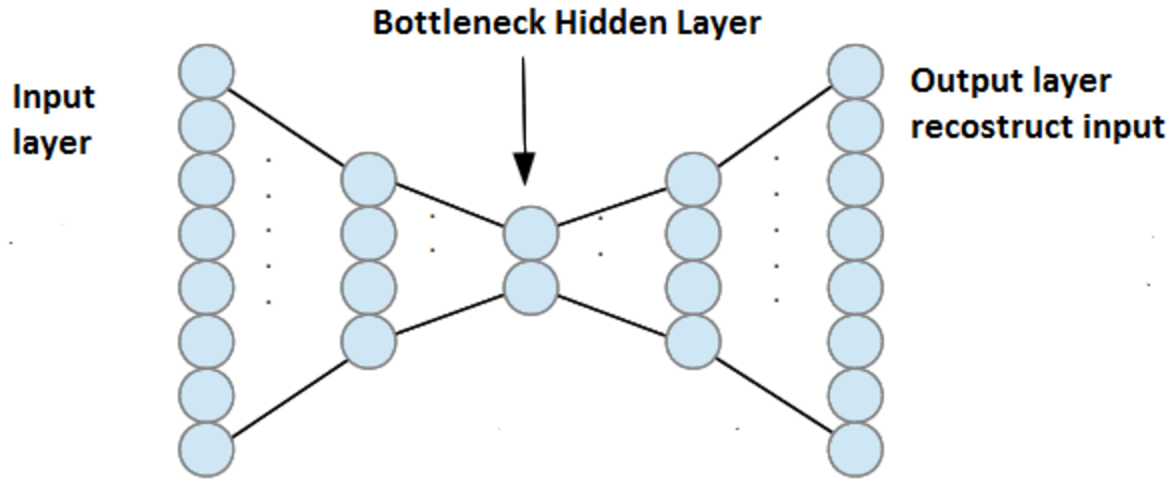

In [5]:
Image('../../sources/autoencoder.png')

### Build Autoencoder using Tensorflow

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

### TensorFlow Notes
    
Placeholders can be thought of as as empty tensors which we insert our data and thus we will need to give the placeholder dimensions which correspond to the shape of the dataset.

After setting up the placeholders, we need to define some variables are the parameters (i.e. represented as tensors). The defined variables will hold the weights and biases of the neural network and will be updated during training. 

Note: TensorFlow variables need to be initialized with values. Therefore, we can use **tf.random_normal** to draw a random sample from a normal distribution to populate a the tensor shape. The weights and bias term are initialized randomly and updated during training via gradient descent.

In [3]:
#Example of Performing Multiplication Operations in TF
a = tf.placeholder('float')
b = tf.placeholder('float')
y = tf.multiply(a,b)

with tf.Session() as ses:
    print('Results: {0:.1f}'.format(ses.run(y,feed_dict={a: 10, b: 12})))

Results: 120.0


### Example: MNIST Dataset

Note: The MNIST data is split into three parts: 55,000 data points of training data (mnist.train) 10,000 points of test data (mnist.test) 5,000 points of validation data (mnist.validation). Each image is 28 pixels by 28 pixels. The images are flatten out into a vector of 28x28 = 784 numbers. Also, each entry in the tensor is a pixel intensity between 0 and 1, for a particular pixel in a particular image.

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/MNIST_data/", one_hot=True)

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
def process_data():
    
    """
    Return preprocessed Training/Testing subsets of the MNIST Images
    
    Keyword arguments:
    None
    """
    
    train = mnist.train.images
    test = mnist.test.images
    print('Original Training Shape:',train.shape)
    
    l = pd.DataFrame(mnist.train.labels)
    labels = l.idxmax(axis=1)
    print('Labels: ',labels.shape[0])
    
    #Reshape Data into 28x28 pixels
    train_r = train.reshape(train.shape[0],28,28)
    test_r = test.reshape(test.shape[0],28,28)
    
    print('Reformat to 28x28 Pixels Shape:',train_r.shape)
    return(train,test,train_r,test_r,labels)
        

#Get Data
X_train,X_test,X_train_r,X_test_r,y_labels = process_data()

Original Training Shape: (55000, 784)
Labels:  55000
Reformat to 28x28 Pixels Shape: (55000, 28, 28)


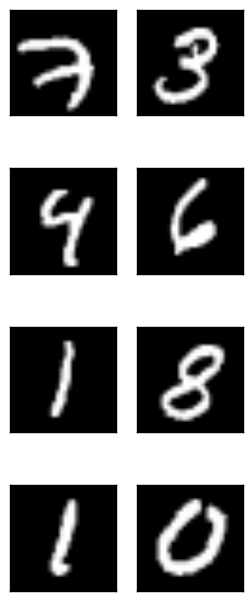

In [52]:
def plt_gallery(x,n_col=4,n_row=2):
    
    """Returns Photo Gallery of Images
    
    Keyword arguments:
    x -- input data
    n_col -- number of columns for subplot
    n_row -- number of rows for subplot
    
    """
    
    fig = plt.figure(figsize=(3,8))
    plt.subplots_adjust(hspace=0.10,wspace=0.20)
    for img,i in enumerate(range(n_row*n_col)):
        plt.subplot(n_col,n_row,i+1)
        plt.imshow(x[img],cmap='gray',interpolation=None)
        plt.xticks(())
        plt.yticks(())
        
#Original MNIST Images
plt_gallery(X_train_r)

### **Build Autoencoder**

In [7]:
class Autoencoder(object):
    
    "Build Deep Autoencoder using TenorFlow API"
    
    def __init__(self,architecture):

        #Network Structure
        self.structure = architecture
        
        #Input Features
        self.X = tf.placeholder(tf.float32,[None,self.structure['n_inputs']])
        
        #Initialize Build
        self.X_pred = self.build_model()
        
        #Initialize Optimization
        self.optimization()
        
        #Initalize Global Variables
        init_g = tf.global_variables_initializer()

        #Create Tensorflow Session
        self.sess = tf.Session() 
        self.sess.run(init_g)

        
    def initialize_weights(self):
        
        """
        Returns weights and biases
        
        Note: initialized tensors without scaling variance update using gradient descent;
        
        """
        
        s = self.structure
        initializer = tf.contrib.layers.variance_scaling_initializer()
        
        weights = {
    
            #Encoded Hidden Layers Weights
            'weights1': tf.Variable(initializer([s['n_inputs'], s['hidden1']])),
            'weights2': tf.Variable(initializer([s['hidden1'], s['hidden2']])),
            
            #Decoded Hidden Layers Weights
            'weights3': tf.Variable(initializer([s['hidden2'], s['hidden3']])),
            'weights4': tf.Variable(initializer([s['hidden3'], s['n_inputs']])),
            }
    
        biases = {
            
            #Encoded Hidden Layers Biases
            'bias1': tf.Variable(initializer([s['hidden1']])),
            'bias2': tf.Variable(initializer([s['hidden2']])),
            
            #Encoded Hidden Layers Biases
            'bias3': tf.Variable(initializer([s['hidden3']])),
            'bias4': tf.Variable(initializer([s['n_inputs']])),
            }
        
        return(weights,biases)
    
    def build_model(self):
        
        """ Build Neural Network and Update Weights -- Return Reconstructed Output"""
        
        weights,bias = self.initialize_weights()

        #Encoding Activation Output -- tf.matmul multiplies matrix X by matrix w (x.w) -- then summation
        hidden1 = tf.nn.sigmoid(tf.add(tf.matmul(self.X,weights['weights1']),bias['bias1']))

        #Laten Features
        self.latent_feats = tf.add(tf.matmul(hidden1,weights['weights2']),bias['bias2'])
        
        #Encoding Activation Output -- tf.matmul multiplies matrix X by matrix w (x.w) -- then summation
        hidden2 = tf.nn.sigmoid(self.latent_feats)

        #Encoding Activation Output -- tf.matmul multiplies matrix X by matrix w (x.w) -- then summation
        hidden3 = tf.nn.sigmoid(tf.add(tf.matmul(hidden2,weights['weights3']),bias['bias3']))

        #Decoding Hidden layer with Sigmoid Activation #2
        X_pred = tf.nn.sigmoid(tf.add(tf.matmul(hidden3,weights['weights4']),bias['bias4']))
        
        return(X_pred)
    
    
    def optimization(self):
        
        """ Minimize Cost Function -- Mean Squared Error"""

        #Mean Squared Error Loss Function
        self.reconstruction_loss = tf.reduce_mean(tf.pow(self.X - self.X_pred, 2))

        #Optimizer -- Adaptive Moment Estimation (ADAM)
        self.optimizer = tf.train.AdamOptimizer().minimize(self.reconstruction_loss)
        
        
    def partial_fit(self,x):
        
        """ Return Cost for Each Mini-Batch """

        #Pass mini-batch through autoencoder and update weights/cost
        _, cost = self.sess.run([self.optimizer,self.reconstruction_loss],feed_dict={self.X:x})

        return(cost)
        
    def get_reconstruction(self, x):
        
        """ Return the reconstructed output """

        return self.sess.run(self.X_pred,feed_dict={self.X: x})
    
    def get_latent_features(self,x):
        
        """ Return the latent features -- bottleneck layer of network"""
        
        return(self.sess.run(self.latent_feats, feed_dict={self.X: x}))

## Autoencoder with MNIST Dataset

In [35]:
def reconstruction_plot(original,reconstruction,n_cols=2,n_rows=2):
    
    """
    Return original images compared with reconstructed output from Autoencoder
    
    Keyword arguments:
    n_cols -- number of columns for subplot
    n_rows -- number of rows for subplot
    """
    
    #Setup Original Visualization
    fig = plt.figure(figsize=(4*n_cols,4*n_rows))
        
    #Test Dataset Handwritten Images
    for idx, i in enumerate(range(n_cols*n_rows)):
        ax = fig.add_subplot(n_rows,n_cols,idx+1)
        ax.imshow(original[i].reshape([28,28]),cmap='gray')
        ax.set_title('Original Image: {}'.format(idx+1),fontsize=18)

    #Setup Second Visualization
    fig2 = plt.figure(figsize=(4*n_cols,4*n_rows))

    #Test Dataset Reconstructed Handwritten Images
    for idx, i in enumerate(range(n_cols*n_rows)):
        ax = fig2.add_subplot(n_rows,n_cols,idx+1)
        ax.imshow(reconstruction[i].reshape([28,28]),cmap='gray')
        ax.set_title('Reconstructed Img: {}'.format(idx+1),fontsize=18)
            
            
def latent_feats_plot(features,labels):    
    
    """ Return Scatter plot of Latent Features -- X1 vs X2
    
    Keyword arguments:
    features -- input latent feats
    labels -- classification of each image -- labels not used in training
    """
   
    #Create DataFrames
    x,y = pd.DataFrame(features),pd.DataFrame(labels)
    
    #Concatenate Features and Labels
    data = pd.concat([x,y],axis=1)
    
    #Rename Label Column
    cols = ['X{}'.format(i+1) for i in range(data.shape[1] -1)]        
    cols.append('Label')
    data.columns = cols

    fig = plt.figure(figsize=(12,8))
    for idx,digit in enumerate(data.Label.unique()):
        
        #Filter for Unique Handwritten Digit
        u = data[data.Label == digit]
        ax = fig.add_subplot(111)
        colors = cm.spectral(float((idx+1)/10))
        ax.scatter(u.ix[:,'X1'],u.ix[:,'X2'],color=colors,edgecolor=None,s=25,alpha=0.80,label=digit)
        ax.set_ylabel('X2')
        ax.set_xlabel('X1')
        ax.legend(loc=(1.04,.5))
        ax.set_title('Autoencoder: Reconstructed Output',fontsize=20,y=1.02)

            
def neural_net_architecture():
    
    """
    Return dictionary of Neural Netword architecture
    
    Keyword arguments:
    None
    """
    
    struct = {
                'hidden1': 256, 
                'hidden2': 20, 
                'hidden3': 256,  
                'n_inputs': 784, 
             }
    return(struct)

def train_AC(X,batch_size=256,epochs=10000,display_steps=1000):
    
    #Get Autoencoder Structure
    architecture = neural_net_architecture()  
    
    #Initialize Autoencoder
    ae = Autoencoder(architecture)

    print('\n=== Performing Mini-Batch == ')
    print('Number of Steps: ', epochs)
    print('Batch Size: ', batch_size)
    print('\n')
    
    #Training 
    loss,acc = [],[]
    for epoch in range(epochs):
        
        #Get Random Mini-Batch
        rand_idx = np.random.choice(len(X_train),size=batch_size)
        batch_x = X_train[rand_idx]

        #Partial Fit for Mini-Batch
        cost = ae.partial_fit(batch_x)

        #Compute Average Loss
        loss.append(cost / len(batch_x))
            
        if epoch % display_steps == 0 or epoch == 1:
            print('Epoch {0} -- Train MSE: {1:.3f}'.format(epoch,cost))

    return(ae)


=== Performing Mini-Batch == 
Number of Steps:  10000
Batch Size:  256


Epoch 0 -- Train MSE: 0.254
Epoch 1 -- Train MSE: 0.232
Epoch 1000 -- Train MSE: 0.027
Epoch 2000 -- Train MSE: 0.020
Epoch 3000 -- Train MSE: 0.017
Epoch 4000 -- Train MSE: 0.015
Epoch 5000 -- Train MSE: 0.014
Epoch 6000 -- Train MSE: 0.014
Epoch 7000 -- Train MSE: 0.013
Epoch 8000 -- Train MSE: 0.013
Epoch 9000 -- Train MSE: 0.012
CPU times: user 14min 2s, sys: 29.9 s, total: 14min 32s
Wall time: 2min 28s
CPU times: user 378 ms, sys: 45 ms, total: 423 ms
Wall time: 75.8 ms
CPU times: user 814 ms, sys: 46.1 ms, total: 860 ms
Wall time: 140 ms


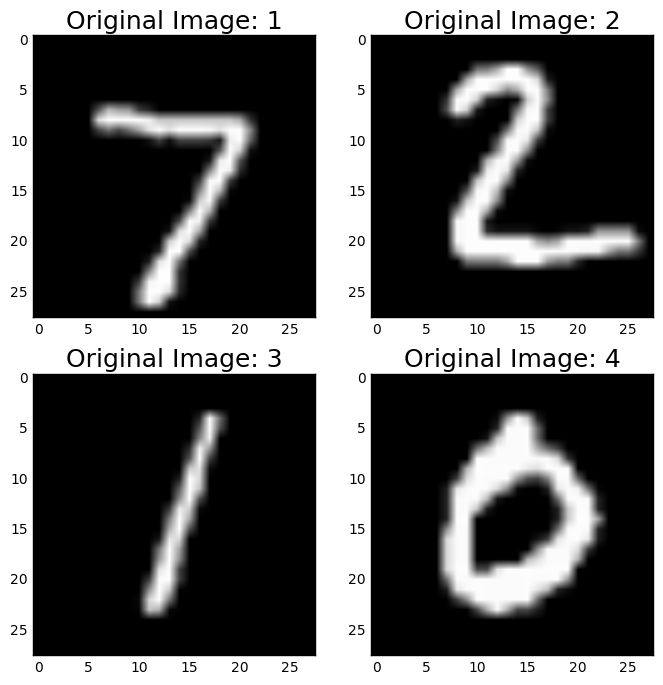

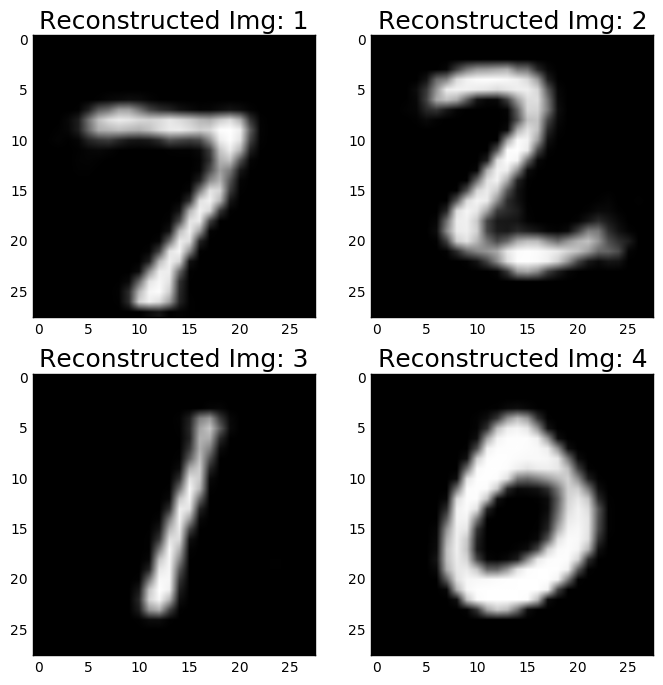

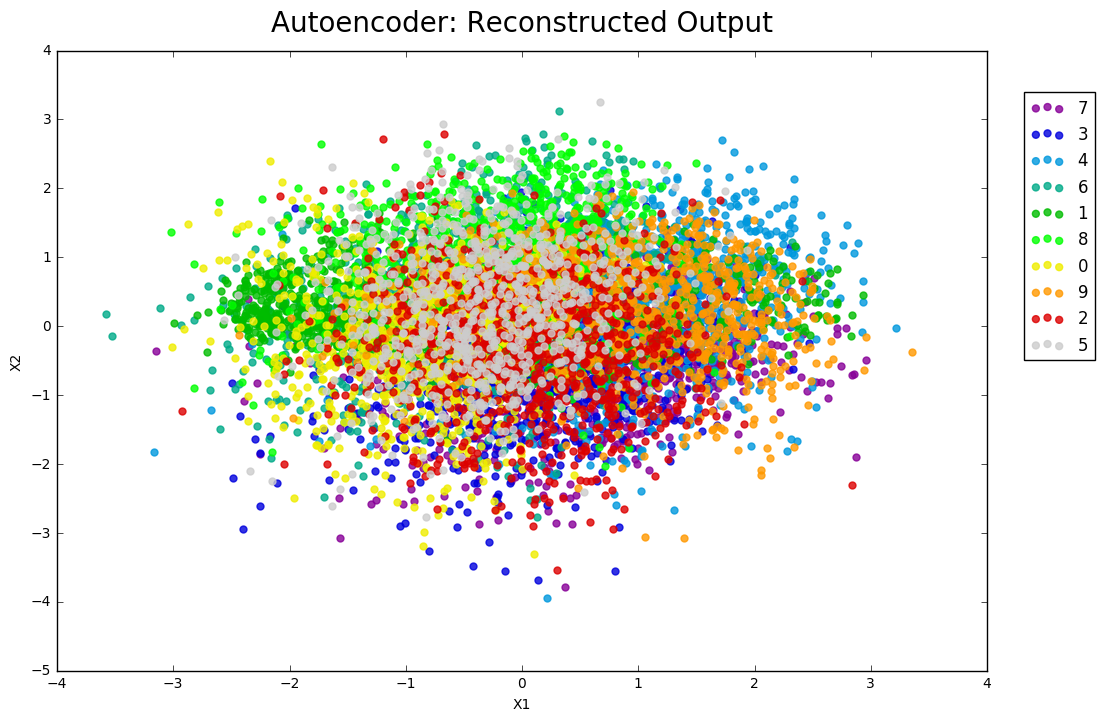

In [36]:
if __name__ == '__main__':
    
    
    #Subset of training/testing set
    n = 10000
    X_train = X_train[:n,:]
    X_test = X_test[:n,:]
    y_labels = y_labels[:n]
    
    #Autoencoder
    %time ae = train_AC(X_train)
    
    #Latent Features
    %time latent = ae.get_latent_features(X_train)
    
    #Reconstructed Output
    %time reconstruct = ae.get_reconstruction(X_test)

    #Get Reconstructed Output
    reconstruction_plot(X_test,reconstruct)
    
    #Scatter plot of Latent Features
    latent_feats_plot(latent,y_labels)

### Iris Dataset

In [172]:
def latent_feats_plot(x,y):
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    ax.scatter(x[:,0],x[:,1],c=y,cmap='spectral',s=25,alpha=0.60)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_title('Latent Features',fontsize=20)
    
    
def do_PCA(X,y):
    
    #Perform Principal Component Analysis
    pc = PCA()
    pc.fit(X)
    pcs = pc.transform(X)

    #Generate Visualization
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    ax.scatter(pcs[:,0],pcs[:,1],c=y,cmap='spectral',s=25,alpha=0.60)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title('Principal Component Anaylsis',fontsize=20)

def neural_net_architecture():
    
    """
    Return dictionary of Neural Netword architecture
    
    Keyword arguments:
    None
    """
    
    struct = {
            'hidden1': 100, 
            'hidden2': 2, 
            'hidden3': 100,  
            'n_inputs': 4, 
            }
    return(struct)


def train_AC(X,batch_size=20,train_steps=10000,display_steps=1000):
    
    #Get Autoencoder Structure
    architecture = neural_net_architecture()  

    #Initialize Autoencoder
    ae = Autoencoder(architecture,batch_size,train_steps,display_steps)

    print('\n=== Performing Mini-Batch == ')
    print('Number of Steps: ', train_steps)
    print('Batch Size: ', batch_size)
    print('\n')
    
    #Training 
    for i in range(1,train_steps+1):
        idx, avg_cost = 0,0
        while idx <= X.shape[0]:
            
            #Create chunks from input dataframe as 'batches'
            x_batch = X[idx:idx + batch_size,:]
            
            idx = idx + batch_size

            #Partial Fit for Mini-Batch    
            cost = ae.partial_fit(x_batch)

            # Compute average loss
            avg_cost += cost / len(x_batch)
            
        if i % display_steps == 0 or i == 1:
            print('Step {0} -- Train MSE: {1:.3f}'.format(i,avg_cost))
            
    return(ae)

In [ ]:
if __name__ == '__main__':
    
    #Iris Dataset 
    X_train = load_iris().data
    y = load_iris().target
    
    #Standardize Explanatory Variables
    X_train_std = StandardScaler().fit_transform(X_train)
    
    #Train Autoencoder
    %time ae = train_AC(X_train_std)
    
    #Latent Features
    %time latent = ae.get_latent_features(X_train_std)

    #Scatter plot of Latent Features
    latent_feats_plot(latent,y)
    
    #Principal Compnent Analysis
    do_PCA(X_train,y)


=== Performing Mini-Batch == 
Number of Steps:  10000
Batch Size:  20


Step 1 -- Train MSE: 0.527
Step 1000 -- Train MSE: 0.233
Step 2000 -- Train MSE: 0.231
Step 3000 -- Train MSE: 0.231
Step 4000 -- Train MSE: 0.231
Step 5000 -- Train MSE: 0.231
